In [2]:
import sys 
sys.path.append('/Users/patroklos/Desktop/delphi_')

import torch as ch
from torch import Tensor
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.kl import kl_divergence

import matplotlib.pyplot as plt
import IPython 

from delphi.distributions.normal import CensoredNormal
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader

TABLE_NAME = 'logs'

In [4]:
args = Parameters({ 
    'samples': 1000, 
    'batch_size': 1, 
    'tol': 1e-1, 
    'lr': 1e-1, 
    'out_dir': '/Users/patroklos/Desktop/exp',
    'exp': 'tryingToDebugCensored', 
    'trials': 10,
    'var': 1.0,
})


Synthetic Data Experiment for 1 Dimensional Censored Gaussian Distributions 

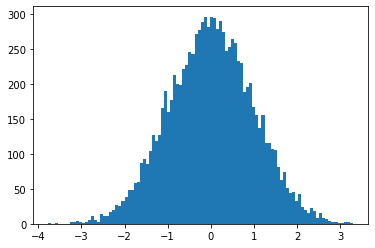

In [95]:
M = MultivariateNormal(Tensor([0.0]), 1.0*ch.ones(1, 1))
samples = M.sample([args.samples])

plt.hist(samples.flatten(), bins=100)
plt.show()

Truncate the Dataset

alpha: 0.8432


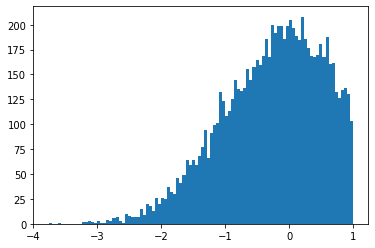

In [96]:
phi = oracle.Right(Tensor([1.0]))
# phi = oracle.Identity()
indices = phi(samples).nonzero()[:,0]
S = samples[indices]
alpha = S.size(0) / samples.size(0)
print("alpha: {}".format(alpha))

plt.hist(S.flatten(), bins=100)
plt.show()

In [97]:
emp_loc = S.mean(0)
print("empirical mean: ", emp_loc)
emp_scale = ch.sqrt(S.var(0))
print("empirical scale: ", emp_scale)

S_norm = (S - emp_loc) / emp_scale
phi_norm = oracle.Right((phi.right - emp_loc) / emp_scale)

empirical mean:  tensor([-0.2742])
empirical scale:  tensor([0.7833])


Run algorithm to Remove Bias from the Dataset

In [98]:
censored = CensoredNormal(phi=phi_norm, 
                          alpha=alpha, 
                          iter_=1, 
                          bs=10, 
                          num_samples=10,
#                           step_lr=100,
#                           step_lr=50,
                          lr=1e-1)
#                           custom_lr_multiplier='adam')
censored.fit(S_norm)

Iteration 1 | Log Likelihood: 0.203


In [99]:
(censored.censored_normal.loc_est * emp_scale + emp_loc).mean()

tensor(-0.1163, grad_fn=<MeanBackward0>)

In [100]:
(censored.censored_normal.cov_est * emp_scale).mean()

tensor(0.5371, grad_fn=<MeanBackward0>)

In [5]:
store = Store(args.out_dir + '/' + args.exp)

schema = { 
    'kl_div_emp': float, 
    'kl_div_censored': float,
    'kl_div_censored_avg': float,

}

store.add_table(TABLE_NAME, schema)

for i in range(args.trials): 
    # create new dataset
    gt_loc, gt_scale = Tensor([0.0]), args.var * ch.ones(1, 1)
    gt_dist = MultivariateNormal(gt_loc, gt_scale)
    samples = gt_dist.sample([args.samples])

    # right truncate at 0
    phi = oracle.Right(Tensor([0.0]))
    indices = phi(samples).nonzero()[:,0]
    S = samples[indices]
    alpha = S.size(0) / samples.size(0)
    
    emp_dist = MultivariateNormal(S.mean(0), S.var(0) * ch.ones(1, 1))

    S_norm = (S - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix) 
    phi_norm = oracle.Right((phi.right - emp_dist.loc) / ch.sqrt(emp_dist.covariance_matrix))
    
    
    censored = CensoredNormal(phi=phi_norm, 
                          alpha=alpha, 
                          iter_=1, 
                          bs=10, 
                          num_samples=100,
                          lr=1e-1)
    censored.fit(S_norm)
    
    
    loc_ = (censored.loc * censored.scale.inverse() * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
    scale_ = censored.scale.inverse() * emp_dist.covariance_matrix
    
    censor_dist = MultivariateNormal(loc_, scale_)
    
    loc_avg_ = (censored.censored_normal.loc_est.mean() * censored.censored_normal.cov_est.mean(1)[None,...].inverse() * ch.sqrt(emp_dist.covariance_matrix)) + emp_dist.loc
    scale_avg_ = censored.censored_normal.cov_est.mean(1)[None,...].inverse() * emp_dist.covariance_matrix
    
    
    censor_dist_avg = MultivariateNormal(loc_avg_, scale_avg_)

    kl_censor = float(kl_divergence(gt_dist, censor_dist))
    kl_censor_avg = float(kl_divergence(gt_dist, censor_dist_avg))
    kl_emp = float(kl_divergence(gt_dist, emp_dist))
    
    
    store[TABLE_NAME].update_row({ 
        'kl_div_emp': kl_emp, 
        'kl_div_censored_avg': kl_censor_avg, 
        'kl_div_censored': kl_censor,
    })
    store[TABLE_NAME].flush_row()
    
store.close()

Logging in: /Users/patroklos/Desktop/exp/tryingToDebugCensored/6fdba0e2-8644-4367-95c3-a5af1a97c30f
Iteration 1 | Log Likelihood: 0.154
Iteration 1 | Log Likelihood: 0.201
Iteration 1 | Log Likelihood: 0.034
Iteration 1 | Log Likelihood: 0.012
Iteration 1 | Log Likelihood: 0.062
Iteration 1 | Log Likelihood: 0.087
Iteration 1 | Log Likelihood: 0.128
Iteration 1 | Log Likelihood: 0.05
Iteration 1 | Log Likelihood: 0.228
Iteration 1 | Log Likelihood: 0.102


In [6]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

100%|██████████| 2/2 [00:00<00:00, 110.38it/s]


,kl_div_emp,kl_div_censored,kl_div_censored_avg,exp_id
0,1.235775,0.001650,0.020101,5db16f6f-6b96-4c79-8b3f-772dd7094934
1,1.253376,0.000701,0.303619,5db16f6f-6b96-4c79-8b3f-772dd7094934
0,1.346924,0.357648,0.742996,6fdba0e2-8644-4367-95c3-a5af1a97c30f
1,1.210746,0.383271,0.534921,6fdba0e2-8644-4367-95c3-a5af1a97c30f
2,1.346981,0.017608,0.585634,6fdba0e2-8644-4367-95c3-a5af1a97c30f
3,1.127310,0.243986,0.625361,6fdba0e2-8644-4367-95c3-a5af1a97c30f
4,1.162476,0.189899,0.529426,6fdba0e2-8644-4367-95c3-a5af1a97c30f
5,1.200236,0.058970,0.510890,6fdba0e2-8644-4367-95c3-a5af1a97c30f
6,1.253638,0.034767,0.473990,6fdba0e2-8644-4367-95c3-a5af1a97c30f
7,1.152331,0.190315,0.541707,6fdba0e2-8644-4367-95c3-a5af1a97c30f


In [7]:
print("kl emp div: {}".format(logs.kl_div_emp.mean()))
print("kl censor div: {}".format(logs.kl_div_censored_avg.mean()))
print("kl censor avg div: {}".format(logs.kl_div_censored.mean()))

kl emp div: 1.2433069745699565
kl censor div: 0.5049001077810923
kl censor avg div: 0.17924688383936882


In [51]:
emp_dist = MultivariateNormal(ch.zeros(1), ch.ones(1, 1))

In [54]:
gt_dist = MultivariateNormal(ch.zeros(1) + .5, ch.ones(1, 1))

In [55]:
kl_divergence(emp_dist, gt_dist)

tensor(0.1250)

In [62]:
censored.scale

tensor([[0.5863]])